In [3]:
pip install geopandas matplotlib descartes networkx

In [5]:
import geopandas as gpd
import networkx as nx
import matplotlib.pyplot as plt
from collections import deque
import random
from collections import defaultdict

# Load the shapefile into a GeoDataFrame
gdf = gpd.read_file('/content/cb_2015_42_tract_500k.shp')

# Print first few rows to understand the stucture
print(gdf.head())

# Check the coordinate reference system (CRS)
gdf = gdf.set_crs('EPSG:4326', allow_override=True)
print(gdf.crs)

                                            geometry
0  POLYGON ((-77.03108 39.80239, -77.02262 39.806...
1  POLYGON ((-79.97927 40.44287, -79.97562 40.444...
2  POLYGON ((-79.91616 40.46699, -79.9146 40.4674...
3  POLYGON ((-79.93304 40.43343, -79.93403 40.437...
4  POLYGON ((-80.03078 40.46212, -80.02462 40.459...
EPSG:4326


In [6]:
# Creating the graph
G = nx.Graph()

# Add nodes (each area is a node)
for idx, row in gdf.iterrows():
    G.add_node(idx, geometry=row["geometry"])

# Add edges based on spatial adjacency
for i, row_i in gdf.iterrows():
    for j, row_j in gdf.iterrows():
        if i != j and row_i["geometry"].touches(row_j["geometry"]):
            G.add_edge(i, j)

print(f"Graph created with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")

Graph created with 3217 nodes and 9570 edges.


In [7]:
def region_growing(graph, max_region_size=800, max_regions=5):
    region_labels = {} # Node number: region number mapping
    region_id = 0

    for start_node in graph.nodes:
        if start_node not in region_labels:
            region = {start_node}
            frontier = {start_node}  # Nodes to be processed

            while frontier and len(region) < max_region_size:
                node = frontier.pop()

                for neighbor in graph.neighbors(node):
                    if neighbor not in region and neighbor not in region_labels:
                        region.add(neighbor)
                        frontier.add(neighbor)

            # Assign all nodes in the region to the current region_id
            for node in region:
                region_labels[node] = region_id

            region_id += 1

            if max_regions is not None and region_id >= max_regions:
                break
    return region_labels

In [8]:
def region_merging(graph, region_labels):
    # Get all the unassigned nodes
    unassigned_nodes = {node for node in graph.nodes if node not in region_labels}
    queue = deque()
    print("Unassigned Nodes")
    print(unassigned_nodes)

    # Get assigned nodes
    for node, region in region_labels.items():
        queue.append(node)

    while unassigned_nodes:
        if not queue:
            node = unassigned_nodes.pop()
            region_labels[node] = max(region_labels.values(), default=-1) + 1
            queue.append(node)

        current_node = queue.popleft()

        for neighbor in graph.neighbors(current_node):
            if neighbor in unassigned_nodes:
                region_labels[neighbor] = region_labels[current_node]
                unassigned_nodes.remove(neighbor)
                queue.append(neighbor)

    return region_labels

In [9]:
def region_splitting(graph, region_labels, max_region_size=800, min_region_size=100, max_regions=5):

    # Group nodes by their region
    region_nodes = defaultdict(set)
    for node, region in region_labels.items():
        region_nodes[region].add(node)

    new_region_labels = region_labels.copy()
    next_region_id = max(region_labels.values()) + 1

    # Get small regions
    small_regions = [r for r, nodes in region_nodes.items() if len(nodes) < min_region_size]

    for region in small_regions:
        if region not in region_nodes:
            continue

        nodes_to_merge = list(region_nodes[region])
        merged = False

        for node in nodes_to_merge:
            for neighbor in graph.neighbors(node):
                neighbor_region = new_region_labels.get(neighbor)

                if neighbor_region and neighbor_region != region and len(region_nodes[neighbor_region]) + len(nodes_to_merge) <= max_region_size:
                    for merge_node in nodes_to_merge:
                        new_region_labels[merge_node] = neighbor_region
                        region_nodes[neighbor_region].add(merge_node)
                    del region_nodes[region]
                    merged = True
                    break
            if merged:
                break

    # Split oversized regions
    oversized_regions = [r for r, nodes in region_nodes.items() if len(nodes) > max_region_size]

    for region in oversized_regions:
        nodes = list(region_nodes[region])
        random.shuffle(nodes)

        subregions = []
        visited = set()

        while nodes:
            start_node = nodes.pop()
            if start_node in visited:
                continue

            # Grow a subregion using BFS
            queue = deque([start_node])
            subregion = set()

            while queue:
                node = queue.popleft()
                if node in visited:
                    continue

                subregion.add(node)
                visited.add(node)

                for neighbor in graph.neighbors(node):
                    if neighbor in nodes and len(subregion) < max_region_size:
                        queue.append(neighbor)
                        nodes.remove(neighbor)

            subregions.append(subregion)

        # Ensure all subregions meet min_region_size
        valid_subregions = [s for s in subregions if len(s) >= min_region_size]
        leftover_nodes = [node for s in subregions if len(s) < min_region_size for node in s]

        # Distribute leftover nodes
        while leftover_nodes:
            node = leftover_nodes.pop()
            for neighbor in graph.neighbors(node):
                neighbor_region = new_region_labels.get(neighbor)
                if neighbor_region:
                    new_region_labels[node] = neighbor_region
                    break
            else:
                if valid_subregions:
                    new_region_labels[node] = next_region_id
                    valid_subregions[0].add(node)

        # Assign new regions to valid subregions
        for subregion in valid_subregions:
            for node in subregion:
                new_region_labels[node] = next_region_id
            next_region_id += 1

    return new_region_labels


In [10]:
def run_prrp(graph):
    # Phase 1: Region Growing
    region_labels = region_growing(graph)
    print("Initial Region:", region_labels)
    plot_regions(region_labels, "PHASE 1")

    # Phase 2: Region Merging
    merged_regions = region_merging(graph, region_labels)
    print("Merged Regions:", merged_regions)
    plot_regions(merged_regions, "PHASE 2")

    # Phase 3: Region Splitting
    split_regions = region_splitting(graph, merged_regions)
    print("Split Regions:", split_regions)
    plot_regions(split_regions, "PHASE 3")

    return split_regions

In [11]:
def plot_regions(all_regions, region_number):
    gdf['region'] = gdf.index.map(all_regions)

    # Plot the GeoDataFrame with regions as different colors
    fig, ax = plt.subplots(figsize=(10, 6))
    gdf.plot(column="region", cmap="tab10", legend=True, edgecolor="black", ax=ax)

    plt.title(f"Spatial Graph after {region_number}")
    plt.show()

Initial Region: {0: 0, 2049: 0, 2050: 0, 2048: 0, 2054: 0, 2055: 0, 2056: 0, 2058: 0, 2074: 0, 2075: 0, 27: 0, 2077: 0, 2078: 0, 2076: 0, 32: 0, 33: 0, 47: 0, 49: 0, 50: 0, 53: 0, 54: 0, 55: 0, 56: 0, 59: 0, 61: 0, 2110: 0, 62: 0, 63: 0, 2109: 0, 81: 0, 82: 0, 90: 0, 91: 0, 94: 0, 95: 0, 97: 0, 105: 0, 106: 0, 107: 0, 109: 0, 129: 0, 159: 0, 160: 0, 161: 0, 174: 0, 175: 0, 176: 0, 177: 0, 178: 0, 193: 0, 194: 0, 195: 0, 196: 0, 197: 0, 206: 0, 207: 0, 211: 0, 212: 0, 213: 0, 214: 0, 215: 0, 216: 0, 217: 0, 218: 0, 219: 0, 220: 0, 221: 0, 222: 0, 223: 0, 224: 0, 225: 0, 2277: 0, 2290: 0, 2291: 0, 2292: 0, 2293: 0, 248: 0, 249: 0, 250: 0, 2299: 0, 2300: 0, 2305: 0, 260: 0, 261: 0, 262: 0, 263: 0, 264: 0, 265: 0, 266: 0, 270: 0, 271: 0, 272: 0, 2319: 0, 2320: 0, 2323: 0, 2322: 0, 2325: 0, 2324: 0, 2321: 0, 285: 0, 286: 0, 287: 0, 2336: 0, 2335: 0, 2340: 0, 2342: 0, 295: 0, 2345: 0, 298: 0, 2347: 0, 2348: 0, 2349: 0, 2350: 0, 2351: 0, 301: 0, 2353: 0, 2354: 0, 2355: 0, 2352: 0, 2363: 0, 23

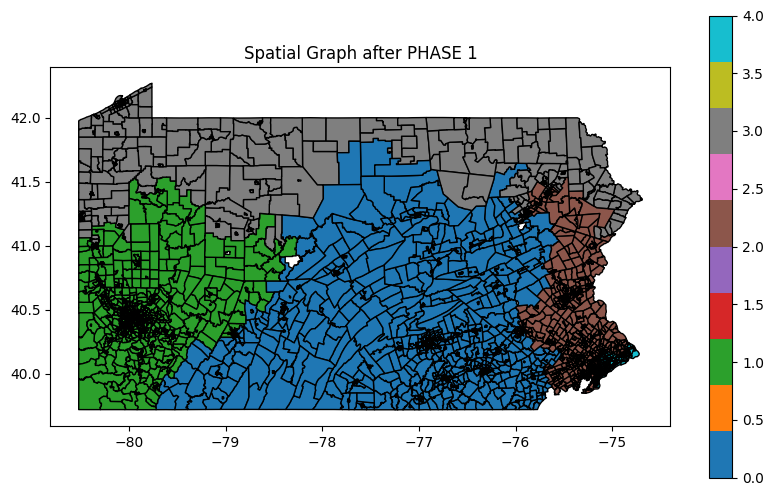

Unassigned Nodes
{1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1546, 1544, 1545, 1547, 1548, 1549, 1550, 1551, 1552, 1554, 1555, 1556, 535, 536, 537, 1557, 1558, 1559, 1560, 1561, 543, 1562, 1563, 1564, 1565, 1060, 1061, 3101, 3125, 3126, 575, 64, 65, 66, 67, 68, 69, 70, 576, 1095, 1096, 2122, 2124, 2125, 595, 85, 2651, 3071, 3164, 3165, 3166, 2149, 2150, 2152, 2664, 2665, 2155, 2666, 2157, 2057, 2158, 2667, 2668, 2669, 2670, 2672, 639, 137, 657, 658, 2708, 670, 671, 672, 1188, 1709, 1207, 1208, 699, 191, 1735, 716, 227, 228, 229, 230, 231, 232, 233, 743, 2787, 2788, 2789, 238, 2790, 2791, 2297, 254, 268, 781, 1313, 1315, 1316, 2346, 299, 300, 1324, 1326, 1327, 2864, 2867, 2932, 2933, 2934, 388, 389, 390, 1430, 2977, 2980, 2986, 3000, 3004, 445, 3014, 1992, 458, 989, 991, 992, 1022, 1023}
Merged Regions: {0: 0, 2049: 0, 2050: 0, 2048: 0, 2054: 0, 2055: 0, 2056: 0, 2058: 0, 2074: 0, 2075: 0, 27: 0, 2077: 0, 2078: 0, 2076: 0, 32: 0, 33: 0, 47: 0, 49: 0, 50: 0, 53: 0,

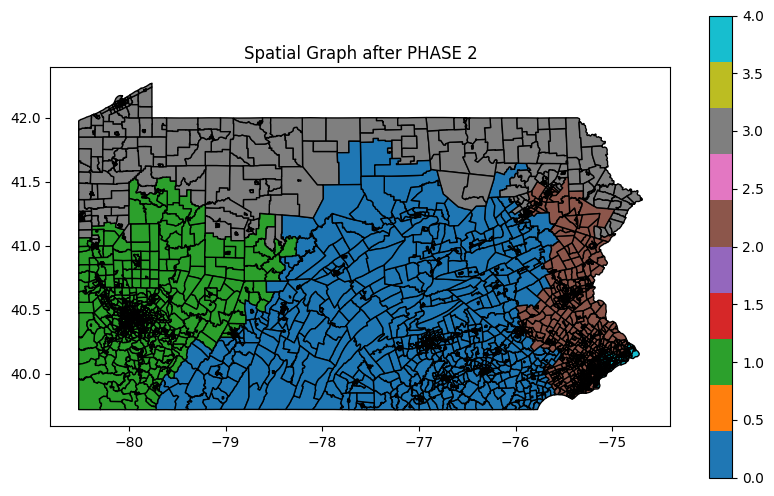

Split Regions: {0: 5, 2049: 5, 2050: 5, 2048: 5, 2054: 5, 2055: 5, 2056: 5, 2058: 5, 2074: 5, 2075: 5, 27: 5, 2077: 5, 2078: 5, 2076: 5, 32: 5, 33: 5, 47: 5, 49: 5, 50: 5, 53: 5, 54: 5, 55: 5, 56: 5, 59: 5, 61: 5, 2110: 5, 62: 5, 63: 5, 2109: 5, 81: 5, 82: 5, 90: 5, 91: 5, 94: 5, 95: 5, 97: 5, 105: 5, 106: 5, 107: 5, 109: 5, 129: 5, 159: 5, 160: 5, 161: 5, 174: 5, 175: 5, 176: 5, 177: 5, 178: 5, 193: 5, 194: 5, 195: 5, 196: 5, 197: 5, 206: 5, 207: 5, 211: 5, 212: 5, 213: 5, 214: 5, 215: 5, 216: 5, 217: 5, 218: 5, 219: 5, 220: 5, 221: 5, 222: 5, 223: 5, 224: 5, 225: 5, 2277: 5, 2290: 5, 2291: 5, 2292: 5, 2293: 5, 248: 5, 249: 5, 250: 5, 2299: 5, 2300: 5, 2305: 5, 260: 5, 261: 5, 262: 5, 263: 5, 264: 5, 265: 5, 266: 5, 270: 5, 271: 5, 272: 5, 2319: 5, 2320: 5, 2323: 5, 2322: 5, 2325: 5, 2324: 5, 2321: 5, 285: 5, 286: 5, 287: 5, 2336: 5, 2335: 5, 2340: 5, 2342: 5, 295: 5, 2345: 5, 298: 5, 2347: 5, 2348: 5, 2349: 5, 2350: 5, 2351: 5, 301: 5, 2353: 5, 2354: 5, 2355: 5, 2352: 5, 2363: 5, 236

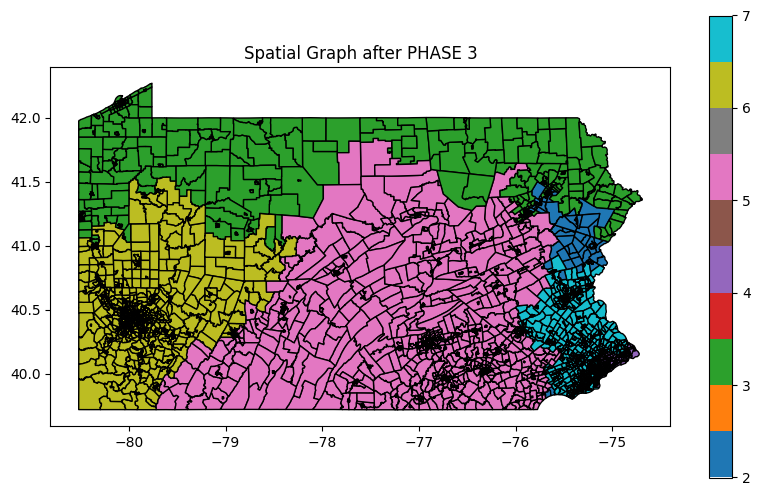

In [13]:
# Run the PRRP algorithm on the graph
final_regions = list(run_prrp(G))